# Tutorial for the Bayesian machine scientist 

This tutorial illustrates how to program a Bayesian machine scientist, using the code provided here. The tutorial assumes general knowledge of Python programming. We start by importing all necessary Python modules:

In [1]:
import sys
import numpy as np 
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
from copy import deepcopy
from ipywidgets import IntProgress
from IPython.display import display

sys.path.append('./')
sys.path.append('./Prior/')
from mcmc import *
from parallel import *
from fit_prior import read_prior_par

## Loading and preparing the data 

We then load the data. In this particular case, we load the salmon stocks data. The features (independent variables) are loaded into a Pandas `DataFrame` named `x`, whereas the target (dependent) variable is loaded into a Pandas `Series` named `y`. Data should **always** be loaded in these formats to avoid problems. 

In [2]:
XLABS = [
    'eff',
    'D_max',
    'D_apr',
    'D_may',
    'D_jun',
    'ET_apr',
    'ET_may',
    'ET_jun',
    'PT_apr',
    'PT_may',
    'PT_jun',
    'PT_jul',
    'PDO_win',
]
raw_data = pd.read_csv('Validation/LogYe/data/seymour.csv')
x, y = raw_data[XLABS], np.log(raw_data['rec'])
x.head()

,eff,D_max,D_apr,D_may,D_jun,ET_apr,ET_may,ET_jun,PT_apr,PT_may,PT_jun,PT_jul,PDO_win
0,0.004697,12500,952,4160,8880,7.8,10.6,14.5,6.7,7.3,8.6,9.7,-1.544
1,0.011504,8040,1650,6040,6020,9.1,12.4,14.5,7.2,8.2,8.9,9.8,-1.012
2,0.002780,8330,1700,5670,6790,8.4,11.4,13.5,7.1,8.0,8.6,9.3,-0.496
3,0.002907,7220,920,4960,6020,9.1,12.2,14.4,7.6,8.5,9.1,9.9,-0.682
4,0.012463,9060,796,4100,7600,8.4,12.3,13.2,7.5,8.3,8.8,9.2,-0.472


## Initializing the Bayesian machine scienstist 

We start by initializing the machine scientist. This involves three steps:
- **Reading the prior hyperparameters.** The values of the hyperparameters depend on the number of variables `nv` and parameters `np`considered during the search. Many combinations of `nv` and `np` have hyperparameters calculated in the `Prior` directory. Otherwise, the hyperparameters should be fit. 
- **Setting the "temperatures" for the parallel tempering.** If you don't know what parallel tempering is, you can read it in the Methods section of the paper, or just leave it as is in the code. In general, more temperatures (here 20) lead to better sampling of the expression space (we use a maximum of 100 different temperatures)
- **Initializing the (parallel) scientist.**

In [3]:
# Read the hyperparameters for the prior
prior_par = read_prior_par('./Prior/final_prior_param_sq.named_equations.nv13.np13.2016-09-01 17:05:57.196882.dat')

# Set the temperatures for the parallel tempering
Ts = [1] + [1.04**k for k in range(1, 20)]

# Initialize the parallel machine scientist
pms = Parallel(
    Ts,
    variables=XLABS,
    parameters=['a%d' % i for i in range(13)],
    x=x, y=y,
    prior_par=prior_par,
)

## Sampling expressions with the Bayesian machine scientist 

We are now ready to start sampling expressions with the Bayesian machine scientist, using MCMC. In its simplest form, one just needs to run the `mcmc_step()` and the `tree_swap()` methods as many times as necessary. `mcmc_step()` performs an MCMC update at each of the temperatures of the parallel tempering, whereas `tree_swap()` attempts to swap the expressions at two consecutive temperatures.

In [4]:
# Number of MCMC steps
nstep = 100

# Draw a progress bar to keep track of the MCMC progress
f = IntProgress(min=0, max=nstep, description='Running:') # instantiate the bar
display(f)

# MCMC
for i in range(nstep):
    # MCMC update
    pms.mcmc_step() # MCMC step within each T
    pms.tree_swap() # Attempt to swap two randomly selected consecutive temps
    # Update the progress bar
    f.value += 1

IntProgress(value=0, description='Running:')

Typically, of course, one wants to do something other than just generate expressions. For example, one may want to keep track of the most plausible (or, equivalently, the minimum description length) model visited so far by the MCMC, or to keep a trace of some of the properties of the sampled expressions. The example below keeps the best model, as well as a trace of all the description lengths visited. Note that, in `Parallel` objects, the relevant expression is stored in the `t1` attribute (which stands for temperature 1).

In [5]:
# Number of MCMC steps
nstep = 3000

# Draw a progress bar to keep track of the MCMC progress
f = IntProgress(min=0, max=nstep, description='Running:') # instantiate the bar
display(f)

# MCMC
description_lengths, mdl, mdl_model = [], np.inf, None
for i in range(nstep):
    # MCMC update
    pms.mcmc_step() # MCMC step within each T
    pms.tree_swap() # Attempt to swap two randomly selected consecutive temps
    # Add the description length to the trace
    description_lengths.append(pms.t1.E)
    # Check if this is the MDL expression so far
    if pms.t1.E < mdl:
        mdl, mdl_model = pms.t1.E, deepcopy(pms.t1)
    # Update the progress bar
    f.value += 1

IntProgress(value=0, description='Running:', max=3000)

So let's take a look at the objects we stored. Here is the best model sampled by the machine scientist:

In [6]:
print('Best model:\t', mdl_model)
print('Desc. length:\t', mdl)

Best model:	 ((eff ** (PT_may / _a7_)) * _a0_)
Desc. length:	 93.8682884509055


And here is the trace of the description length:

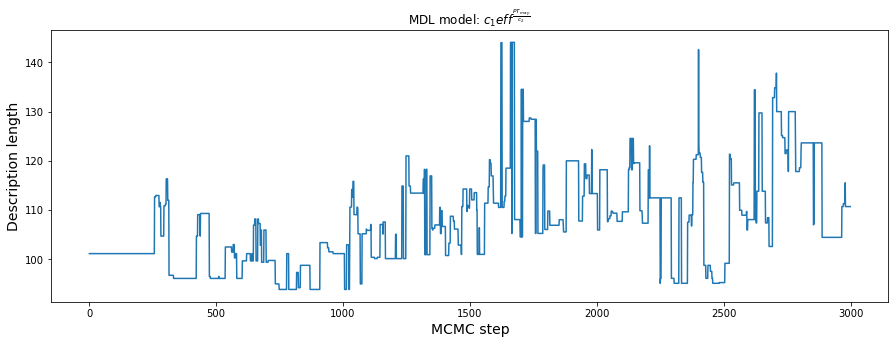

In [7]:
plt.figure(figsize=(15, 5))
plt.plot(description_lengths)
plt.xlabel('MCMC step', fontsize=14)
plt.ylabel('Description length', fontsize=14)
plt.title('MDL model: $%s$' % mdl_model.latex())
plt.show()

## Making predictions with the Bayesian machine scientist 

Finally, we typically want to make predictions with models. In this regard, the interface of the machine scientist is similar to those in Scikit Learn: to make a prediction we call the `predict(x)` method, with an argument that has the same format as the training `x`, that is, a Pandas `DataFrame` with the exact same columns.

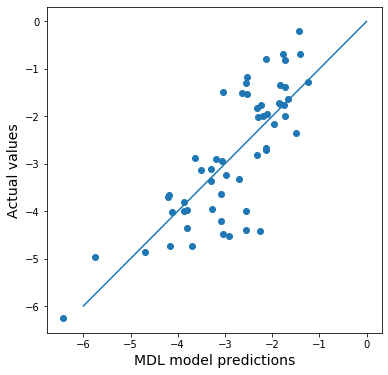

In [8]:
plt.figure(figsize=(6, 6))
plt.scatter(mdl_model.predict(x), y)
plt.plot((-6, 0), (-6, 0))
plt.xlabel('MDL model predictions', fontsize=14)
plt.ylabel('Actual values', fontsize=14)
plt.show()

## Further refinements 

The examples above are only intended to illustrate how a basic MCMC would be implemented. In practice, there are other considerations that we kept in mind in all the experiments reported in the manuscriot, and that anyone using the code should too:
- **Equilibration**: One should not start sampling until the MCMC has converged to the stationary distribution. Although determining when a sample is in equilibrium, a necessary condition is that the description length is not increasing or, more typically, decreasing. The trace of the description length should be flat (except for fluctuations) before we start collecting samples.
- **Thinning**: MCMC samples should be thinned, so only one in, say, 100 samples are kept for the trace. Otherwise, one is getting highly correlated samples, which may lead to, for example, erroneous estimates of confidence intervals.
- **Getting trapped**: Despite the parallel tempering, the MCMC can get trapped in local minima of the description length. For this, we typically keep track of the number of steps since the last `tree_swap()` move was accepted for each temperature. If a particular temperature has *not* accepted swaps in a long time, then we anneal the whole system, that is, we increase all temperatures and decrease them slowly back to equilibrium so as to escape the local minima. Using several restarts of the MCMC and comparing the results is also a convenient check.
- **Memory issues**: By default, the machine scientist keeps a cache of all visited models, so as to avoid duplicates of previously considered models, as well as to speed up the process of obtaining the maximum likelihood estimators of the model parameters. For long MCMC chains this becomes memory intensive, so it may be convenient to periodically clean this cache (or, at least, old models in this cache) by reinitializing the `fit_pat` and `representative` attributes of the `Parallel` instance.